In [7]:
import sys
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
from scipy import stats
from scipy.stats import rankdata
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics, preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
np.random.seed(1)

In [8]:
df = pd.read_csv('compas-scores-two-years.csv')

In [9]:
# description of columns
# sex	Sex of inmate (male/female)
# age	Age of inmate
# age_cat	Age of inmate as a categorical variable(Less than 25/25-45/Greater than 45)
# race	Race of inmate (Caucasian/African American/Asian/Hispanic/Native American/Other)
# priors_count	The count of prior adult convictions
# two_year_recid	Does the inmate recidivicate with 2 years after out of jail? (1/0)
# r_charge_desc	Description of the last crime of the inmate
# c_charge_desc	Type of the crime
# c_charge_degree	Charge of the crime: Felony (F)/ Misdemeanor(M)
# r_charge_degree	Degree of the charge of the crime: (F1/F2/F3/F5/F6/F7/M1/M2/MO3/CO3)
# juv_other_count	Times of crimes commited as juvenile
# length_of_stay	Days stayed in jail
# Recidivicated	Whether the inmate recidivicated or not (Recidivate or notRecidivate)
# is_violent_recid	Whether the recidivicated crimes violent or not (1 or 0)

In [10]:
# df = df[['sex', 'juv_fel_count', 'priors_count', 'race', 'age_cat', 'juv_misd_count', 'c_charge_degree', 'juv_other_count', 'is_recid']]
# these attributes were used in "Exacerbating Algorithmic Bias through Fairness Attacks" Mehrabi et al.

In [11]:
df=df[['event', 'is_violent_recid',
       'is_recid', 'priors_count', 'juv_other_count',
       'juv_misd_count', 'juv_fel_count', 'race', 'age_cat', 'sex','score_text']]
# attributes used in Lewis

**Pre-processing** (categorical to numerical)

In [12]:
 def preprocess(df):
    df['age_cat'] = df['age_cat'].map({'Less than 25': 0, '25 - 45': 1, 'Greater than 45': 2}).astype(int)    
    df['score_text'] = df['score_text'].map({'Low': 0, 'Medium': 1, 'High': 2}).astype(int)    
    df['race'] = df['race'].map({'Other': 0, 'African-American': 0, 'Hispanic': 0, 'Native American': 0, 'Asian': 0, 'Caucasian': 1}).astype(int)    
    df['sex'] = df['sex'].map({'Male': 1, 'Female': 0}).astype(int)    
    
    df.loc[(df['priors_count'] <= 5), 'priors_count'] = 0
    df.loc[(df['priors_count'] > 5) & (df['priors_count'] <= 15), 'priors_count'] = 1
    df.loc[(df['priors_count'] > 15), 'priors_count'] = 2
    
    df.loc[(df['juv_fel_count'] == 0), 'juv_fel_count'] = 0
    df.loc[(df['juv_fel_count'] == 1), 'juv_fel_count'] = 1
    df.loc[(df['juv_fel_count'] > 1), 'juv_fel_count'] = 2
    
    df.loc[(df['juv_misd_count'] == 0), 'juv_misd_count'] = 0
    df.loc[(df['juv_misd_count'] == 1), 'juv_misd_count'] = 1
    df.loc[(df['juv_misd_count'] > 1), 'juv_misd_count'] = 2
    
    df.loc[(df['juv_other_count'] == 0), 'juv_other_count'] = 0
    df.loc[(df['juv_other_count'] == 1), 'juv_other_count'] = 1
    df.loc[(df['juv_other_count'] > 1), 'juv_other_count'] = 2
    return df

df = preprocess(df)

y = df['is_recid']
# y = df['is_violent_recid']
df = df.drop(columns=['is_recid', 'is_violent_recid'])

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

**Protected, privileged**

In [13]:
# protected: 'gender'=0
# privileged: 'gender'=1

# protected: 'race'=0
# privileged: 'race'=1

**Parametric Model**

In [14]:
# size=500
# X_train = X_train[0:size]
# y_train = y_train[0:size]

X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data: regularization penalty default: ‘l2’, ‘lbfgs’ solvers support only l2 penalties. 
# Regularization makes the predictor dependent on the scale of the features.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

clf = LogisticRegression(random_state=0, max_iter=300)

**Compute fairness metric**

In [15]:
def computeFairness(y_pred, X_test, y_test, metric): 
    fairnessMetric = 0
    protected_idx = X_test[X_test['race']==0].index
    numProtected = len(protected_idx)
    privileged_idx = X_test[X_test['race']==1].index
    numPrivileged = len(privileged_idx)
        
    p_protected = 0
    for i in range(len(protected_idx)):
        p_protected += y_pred[protected_idx[i]][1]
    p_protected /= len(protected_idx)
    
    p_privileged = 0
    for i in range(len(privileged_idx)):
        p_privileged += y_pred[privileged_idx[i]][1]
    p_privileged /= len(privileged_idx)
    
    # statistical parity difference
    statistical_parity = p_protected - p_privileged
    
    # equality of opportunity, or 
    # true positive rate parity
    # P(outcome=1 | Y=1, G=0)- P(outcome=1 | Y=1, G=1)
    true_positive_protected = 0
    actual_positive_protected = 0
    for i in range(len(protected_idx)):
        if (y_test[protected_idx[i]] == 1):
            actual_positive_protected += 1
#             if (y_pred[protected_idx[i]][1] > y_pred[protected_idx[i]][0]):
            true_positive_protected += y_pred[protected_idx[i]][1]
    tpr_protected = true_positive_protected/actual_positive_protected
    
    true_positive_privileged = 0
    actual_positive_privileged = 0
    for i in range(len(privileged_idx)):
        if (y_test[privileged_idx[i]] == 1):
            actual_positive_privileged += 1
#             if (y_pred[privileged_idx[i]][1] > y_pred[privileged_idx[i]][0]):
            true_positive_privileged += y_pred[privileged_idx[i]][1]
    tpr_privileged = true_positive_privileged/actual_positive_privileged
    
    tpr_parity = tpr_protected - tpr_privileged
    
    # equalized odds or TPR parity + FPR parity
    # false positive rate parity
    
    # predictive parity
    p_o1_y1_s1 = 0
    p_o1_s1 = 0
    for i in range(len(protected_idx)):
#         if (y_pred[protected_idx[i]][1] > y_pred[protected_idx[i]][0]):
        p_o1_s1 += y_pred[protected_idx[i]][1]
        if (y_test[protected_idx[i]] == 1):
            p_o1_y1_s1 += y_pred[protected_idx[i]][1]
    ppv_protected = p_o1_y1_s1/p_o1_s1
    
    p_o1_y1_s0 = 0
    p_o1_s0 = 0
    for i in range(len(privileged_idx)):
#         if (y_pred[privileged_idx[i]][1] > y_pred[privileged_idx[i]][0]):
        p_o1_s0 += y_pred[privileged_idx[i]][1]
        if (y_test[privileged_idx[i]] == 1):
            p_o1_y1_s0 += y_pred[privileged_idx[i]][1]
    ppv_privileged = p_o1_y1_s0/p_o1_s0
    
    predictive_parity = ppv_protected - ppv_privileged
    
    if (metric == 0):
        fairnessMetric = statistical_parity
    elif (metric == 1):
        fairnessMetric = tpr_parity
    elif (metric == 2):
        fairnessMetric = predictive_parity
        
    return fairnessMetric

**Influence of points computed using ground truth**

In [16]:
def ground_truth_influence(X_train, y_train, X_test, X_test_orig, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig, y_test, 0)

    delta_spd = []
    for i in range(len(X_train)):
        X_removed = np.delete(X_train, i, 0)
        y_removed = y_train.drop(index=i, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd_i = computeFairness(y_pred, X_test_orig, y_test, 0) - spd_0
        delta_spd.append(delta_spd_i)
    
    return delta_spd

**Loss function** (Log loss for logistic regression)

In [17]:
def logistic_loss(y_true, y_pred):
    loss = 0
    for i in range(len(y_true)):
        if (y_pred[i][1] != 0 and y_pred[i][0] != 0):
            loss += - y_true[i] * math.log(y_pred[i][1]) - (1 - y_true[i]) * math.log(y_pred[i][0])
    loss /= len(y_true)
    return loss

**Compute Accuracy** 

In [18]:
from sklearn.metrics import accuracy_score

def computeAccuracy(y_true, y_pred):
    accuracy = 0
    for i in range(len(y_true)):
        idx = y_true[i]
        if (y_pred[i][idx] > y_pred[i][1 - idx]):
            accuracy += 1
#         accuracy += y_pred[i][idx]
    accuracy /= len(y_true)
    return accuracy

**First-order derivative of loss function at z with respect to model parameters**

In [19]:
def del_L_del_theta_i(num_params, y_true, x, y_pred):
#     del_L_del_theta = np.ones((num_params, 1)) * ((1 - y_true) * y_pred[1] - y_true * y_pred[0])
    del_L_del_theta = np.ones((num_params, 1)) * (- y_true + y_pred[1])
    for j in range(1, num_params):
            del_L_del_theta[j] *=  x[j-1]
    return del_L_del_theta

**Hessian: Second-order partial derivative of loss function with respect to model parameters**

In [20]:
def hessian_one_point(num_params, x, y_pred):
    H = np.ones((num_params, num_params)) * (y_pred[0] * y_pred[1])
    for i in range(1, num_params):
        for j in range(i + 1):
            if j == 0:
                H[i][j] *= x[i-1]
            else:
                H[i][j] *= x[i-1] * x[j-1] 
    i_lower = np.tril_indices(num_params, -1)
    H.T[i_lower] = H[i_lower]     
    return H

**First-order derivative of $P(y \mid \textbf{x})$ with respect to model parameters**

In [21]:
def del_f_del_theta_i(num_params, x, y_pred):
    del_f_del_theta = np.ones((num_params, 1)) * (y_pred[0] * y_pred[1])
    for j in range(1, num_params):
            del_f_del_theta[j] *=  x[j-1]
    return del_f_del_theta

**Computing $v=\nabla($Statistical parity difference$)$**

In [22]:
# Return v = del(SPD)/del(theta)
def del_spd_del_theta(num_params, X_test_orig, X_test, y_pred):
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    numPrivileged = X_test_orig['race'].sum()
    numProtected = len(X_test_orig) - numPrivileged
    for i in range(len(X_test)):
        del_f_i = del_f_del_theta_i(num_params, X_test[i], y_pred[i])
        if X_test_orig.iloc[i]['race'] == 1: #privileged
            del_f_privileged = np.add(del_f_privileged, del_f_i)
        elif X_test_orig.iloc[i]['race'] == 0:
            del_f_protected = np.add(del_f_protected, del_f_i)
    del_f_privileged /= numPrivileged
    del_f_protected /= numProtected
    v = np.subtract(del_f_protected, del_f_privileged)
    return v

**Computing $v=\nabla($TPR parity difference$)$**

In [23]:
# Return v = del(TPR_parity)/del(theta)
def del_tpr_parity_del_theta(num_params, X_test_orig, X_test, y_pred, y_test):
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    
    protected_idx = X_test_orig[X_test_orig['race']==0].index
    privileged_idx = X_test_orig[X_test_orig['race']==1].index

    actual_positive_privileged = 0
    for i in range(len(privileged_idx)):
        if (y_test[privileged_idx[i]] == 1):
            actual_positive_privileged += 1
#             if (y_pred[privileged_idx[i]][1] > y_pred[privileged_idx[i]][0]):
            del_f_i = del_f_del_theta_i(num_params, X_test[privileged_idx[i]], y_pred[privileged_idx[i]])
            del_f_privileged = np.add(del_f_privileged, del_f_i)
    del_f_privileged /= actual_positive_privileged
    
    actual_positive_protected = 0
    for i in range(len(protected_idx)):
        if (y_test[protected_idx[i]] == 1):
            actual_positive_protected += 1
#             if (y_pred[protected_idx[i]][1] > y_pred[protected_idx[i]][0]):
            del_f_i = del_f_del_theta_i(num_params, X_test[protected_idx[i]], y_pred[protected_idx[i]])
            del_f_protected = np.add(del_f_protected, del_f_i)
    del_f_protected /= actual_positive_protected

    v = np.subtract(del_f_protected, del_f_privileged)
    return v

**Computing $v=\nabla($Predictive parity difference$)$**

In [24]:
# Return v = del(Predictive_parity)/del(theta)
def del_predictive_parity_del_theta(num_params, X_test_orig, X_test, y_pred, y_test):
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    
    protected_idx = X_test_orig[X_test_orig['race']==0].index
    privileged_idx = X_test_orig[X_test_orig['race']==1].index

    u_dash_protected = np.zeros((num_params, 1))
    v_protected = 0
    v_dash_protected = np.zeros((num_params, 1))
    u_protected = 0
    for i in range(len(protected_idx)):
        del_f_i = del_f_del_theta_i(num_params, X_test[protected_idx[i]], y_pred[protected_idx[i]])
#         if (y_pred[protected_idx[i]][1] > y_pred[protected_idx[i]][0]):
        v_protected += y_pred[protected_idx[i]][1]
        v_dash_protected = np.add(v_dash_protected, del_f_i)
        if (y_test[protected_idx[i]] == 1):
            u_dash_protected = np.add(u_dash_protected, del_f_i)
            u_protected += y_pred[protected_idx[i]][1]
    del_f_protected = (u_dash_protected * v_protected - u_protected * v_dash_protected)/(v_protected * v_protected)
    
    u_dash_privileged = np.zeros((num_params, 1))
    v_privileged = 0
    v_dash_privileged = np.zeros((num_params, 1))
    u_privileged = 0
    for i in range(len(privileged_idx)):
        del_f_i = del_f_del_theta_i(num_params, X_test[privileged_idx[i]], y_pred[privileged_idx[i]])
#         if (y_pred[privileged_idx[i]][1] > y_pred[privileged_idx[i]][0]):
        v_privileged += y_pred[privileged_idx[i]][1]
        v_dash_privileged = np.add(v_dash_privileged, del_f_i)
        if (y_test[privileged_idx[i]] == 1):
            u_dash_privileged = np.add(u_dash_privileged, del_f_i)
            u_privileged += y_pred[privileged_idx[i]][1]
    del_f_privileged = (u_dash_privileged * v_privileged - u_privileged * v_dash_privileged)/(v_privileged * v_privileged)
    
    v = np.subtract(del_f_protected, del_f_privileged)
    return v

**Stochastic estimation of Hessian vector product (involving del fairness): $H_{\theta}^{-1}v = H_{\theta}^{-1}\nabla_{\theta}f(z, \theta) = v + [I - \nabla_{\theta}^2L(z_{s_j}, \theta^*)]H_{\theta}^{-1}v$**

In [25]:
# Uniformly sample t points from training data 
def hessian_vector_product(num_params, n, size, v, hessian_all_points):
    if (size > n):
        size = n
    sample = random.sample(range(n), size)
    hinv_v = copy.deepcopy(v)
    for idx in range(size):
        i = sample[idx]
        hessian_i = hessian_all_points[i]
        hinv_v = np.matmul(np.subtract(np.identity(num_params), hessian_i), hinv_v)
        hinv_v = np.add(hinv_v, v)
    return hinv_v

**First-order influence computation**

In [26]:
def first_order_influence(del_L_del_theta, hinv_v, n):
    infs = []
    for i in range(n):
        inf = -np.dot(del_L_del_theta[i].transpose(), hinv_v)
        inf *= -1/n
        infs.append(inf[0][0].tolist())
    return infs

**Second-order influence computation for a group of points in subset U**

In [27]:
def second_order_influence(X_train, U, size, del_L_del_theta, hessian_all_points):
    u = len(U)
    s = len(X_train)
    p = u/s
    c1 = (1 - 2*p)/(s * (1-p)**2)
    c2 = 1/((s * (1-p))**2)
    num_params = len(del_L_del_theta[0])
    del_L_del_theta_hinv = np.zeros((num_params, 1))
    del_L_del_theta_sum = np.zeros((num_params, 1))
    hessian_U = np.zeros((num_params, num_params))
    for i in range(u):
        idx = U[i]
        hessian_U = np.add(hessian_U, s * hessian_all_points[idx])
        del_L_del_theta_sum = np.add(del_L_del_theta_sum, del_L_del_theta[idx])
    
    hinv_del_L_del_theta= np.matmul(hinv_exact, del_L_del_theta_sum)
    hinv_hessian_U = np.matmul(hinv_exact, hessian_U)
    term1 = c1 * hinv_del_L_del_theta
    term2 = c2 * np.matmul(hinv_hessian_U, hinv_del_L_del_theta)
    sum_term = np.add(term1, term2)
    return sum_term

**Metrics: Initial state**

In [28]:
clf.fit(X_train, y_train)
num_params = len(clf.coef_.transpose()) + 1 #weights and intercept; params: clf.coef_, clf.intercept_
y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  0.1141183433861288
Initial TPR parity:  0.027076868274455768
Initial predictive parity:  0.026473352225881874
Initial loss:  0.22119003355216119
Initial accuracy:  0.9085239085239085


**Pre-compute: (1) Hessian (2) del_L_del_theta for each training data point**

In [29]:
del_L_del_theta = []
for i in range(int(len(X_train))):
    del_L_del_theta.insert(i, del_L_del_theta_i(num_params, y_train[i], X_train[i], y_pred_train[i]))

hessian_all_points = []
for i in range(len(X_train)):
    hessian_all_points.insert(i, hessian_one_point(num_params, X_train[i], y_pred_train[i])
                              /len(X_train))

*Select delta fairness function depending on selected metric*

In [30]:
metric = 2
if metric == 0:
    v1 = del_spd_del_theta(num_params, X_test_orig, X_test, y_pred_test)
elif metric == 1:
    v1 = del_tpr_parity_del_theta(num_params, X_test_orig, X_test, y_pred_test, y_test)
elif metric == 2:
    v1 = del_predictive_parity_del_theta(num_params, X_test_orig, X_test, y_pred_test, y_test)

*H^{-1} computation*

In [31]:
hexact = 1
if hexact == 1: 
    H_exact = np.zeros((num_params, num_params))
    for i in range(len(X_train)):
        H_exact = np.add(H_exact, hessian_all_points[i])
    hinv_exact = np.linalg.pinv(H_exact) 
    hinv_v = np.matmul(hinv_exact, v1)
else: #using Hessian vector product
    size_hvp = int(len(X_train) * .01)
    hinv_v = hessian_vector_product(num_params, len(X_train), size_hvp, v1, hessian_all_points)

**First-order influence of each training data point**

In [32]:
infs_1 = first_order_influence(del_L_del_theta, hinv_v, len(X_train))

**Checking ground truth, first-order and second-order influences for a set**

In [204]:
if metric == 0:
    print("Statistical parity ")
elif metric == 1:
    print("True positive rate parity ")
elif metric == 2:
    print("Predictive parity")
    
active = 1
if active:
    predicates = [ 'age']
    idx=X_train_orig.index 
    for pred in predicates:
       idx0 = X_train_orig[(X_train_orig[pred] == 1)].index 
       idx=idx.intersection(idx0)
      
    print("#Rows removed: ", len(idx))
    print("#Rows left: ", len(X_train) - len(idx))
    X = np.delete(X_train, idx, 0)
    y = y_train.drop(index=idx, inplace=False)
    clf.fit(X, y)
    y_pred_test = clf.predict_proba(X_test)
    print("Ground truth influence of subset (on statistical parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 0) - spd_0)
    print("Ground truth influence of subset (on tpr parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 1) - tpr_parity_0)
    print("Ground truth influence of subset (on predictive parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 2) - predictive_parity_0)

    del_f_1 = 0
    for i in range(len(idx)):
        del_f_1 += infs_1[idx[i]]
    print("First-order influence: ", del_f_1)

    size_hvp = 1
    params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
    del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]
    print("Second-order influence: ", del_f_2)
    
    spd_1 = computeFairness(y_pred_test, X_test_orig, y_test, 0)
    print("Ground truth statistical parity after removing subset: ", spd_1)
    
    tpr_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1)
    print("Ground truth tpr parity after removing subset: ", tpr_parity_1)

    predictive_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1)
    print("Ground truth predictive parity after removing subset: ", predictive_parity_1)

    loss_1 = logistic_loss(y_test, y_pred_test)
    print("Loss after removing subset: ", loss_1)

    accuracy_1 = computeAccuracy(y_test, y_pred_test)
    print("Accuracy after removing subset: ", accuracy_1)

Statistical parity 


KeyError: 'age'

In [33]:
print(spd_0, tpr_parity_0, preditive_parity_0, loss_0, accuracy_0)
print(spd_1, tpr_parity_1, predictive_parity_1, loss_1, accuracy_1)

-0.20044233691822827 -0.17393358242162493 0.3597551530603338 0.8310092961487384
-0.1225835505238218 -0.01100904749147602 0.3789946670357515 0.8205179282868525


**Fairness: Ground-truth subset influence vs. computed subset influences: Random subset**

In [234]:
print("Ground-truth subset, Add 1st-order inf individual, Second-order subset influence")
sampleSize = int(.2 * len(X_train))
for i in range(100):
    idx = random.sample(range(1, len(X_train)), sampleSize) 
    
    # Ground truth subset influence
    X = np.delete(X_train, idx, 0)
    y = y_train.drop(index=idx, inplace=False)
    clf.fit(X, y)
    y_pred_test = clf.predict_proba(X_test)
    inf_gt = computeFairness(y_pred_test, X_test_orig, y_test, 0) - spd_0
    
    # First-order subset influence
    del_f_1 = 0
    for i in range(len(idx)):
        del_f_1 += infs_1[idx[i]]
    
    # Second-order subset influence
    size_hvp = 1
    params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
    del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]
    
#     print(inf_gt, del_f_1, del_f_2, sep=", ")

Ground-truth subset, Add 1st-order inf individual, Second-order subset influence


**Fairness: Ground-truth subset influence vs. computed subset influences: Coherent subset** 

(by coherent, we mean group of data points that share some properties)

<AxesSubplot:>

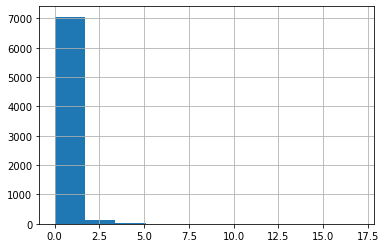

In [176]:
df['juv_other_count'].hist()

In [33]:
print("Attribute, Value, Ground-truth subset, Add 1st-order inf individual, \
Second-order subset influence, %rowsRemoved, Accuracy")
clf.fit(X_train, y_train)
for col in X_train_orig.columns:
    vals = X_train_orig[col].unique()
    for val in vals:
#         print(col, val, sep=": ")
        idx = X_train_orig[X_train_orig[col] == val].index 
    
        X = np.delete(X_train, idx, 0)
        y = y_train.drop(index=idx, inplace=False)
        inf_gt = 0
        if len(y.unique()) > 1:
            # Ground truth subset influence
            clf.fit(X, y)
            y_pred = clf.predict_proba(X_test)
            if metric == 0:
                inf_gt = computeFairness(y_pred, X_test_orig, y_test, 0) - spd_0
            elif metric == 1:
                inf_gt = computeFairness(y_pred, X_test_orig, y_test, 1) - tpr_parity_0
            elif metric == 2:
                inf_gt = computeFairness(y_pred, X_test_orig, y_test, 2) - predictive_parity_0
            accuracy = computeAccuracy(y_test, y_pred)

            # First-order subset influence
            del_f_1 = 0            
            for i in range(len(idx)):
                del_f_1 += infs_1[idx[i]]

            # Second-order subset influence
            size_hvp = 1
            params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
            del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]

            print(col, val, inf_gt, del_f_1, del_f_2, len(idx)/len(X_train), accuracy, sep=", ")

Attribute, Value, Ground-truth subset, Add 1st-order inf individual, Second-order subset influence, %rowsRemoved, Accuracy
event, 1, 0.07874570756472943, 5.318593107702603e-05, 0.000171996709142683, 0.3800034656038815, 0.5474705474705475
priors_count, 1, 0.007570836047698926, 0.006762594089373776, 0.007807401935665577, 0.173626754461965, 0.9099099099099099
priors_count, 0, -0.029068590899494984, -0.00562136747911325, -0.038856443362916084, 0.7879050424536476, 0.9064449064449065
priors_count, 2, -0.0009690017224928127, -0.000887180522362561, -0.0009419546051544658, 0.038468203084387455, 0.9085239085239085
juv_other_count, 2, 0.005206844505824093, 0.003638675794325552, 0.004281349733050933, 0.02235314503552244, 0.9085239085239085
juv_other_count, 0, -0.00596499682559426, -0.003494489804704684, -0.0014243651276616663, 0.9272223184889967, 0.8683298683298684
juv_other_count, 1, -6.409598136680739e-05, 0.00010986009827703359, -6.575310060001583e-05, 0.050424536475480855, 0.9071379071379071
j